In [2]:
from matplotlib import pyplot as plt
# from IPython import display
# display.set_matplotlib_formats("svg")
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.labelsize"] = "medium"
plt.rcParams["ytick.labelsize"] = "medium"
plt.style.library['seaborn-paper']

/tmp/ipykernel_300017/2412676890.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.library['seaborn-paper']


RcParams({'axes.labelsize': 8.8,
          'axes.titlesize': 9.6,
          'figure.figsize': [6.4, 4.4],
          'grid.linewidth': 0.8,
          'legend.fontsize': 8.0,
          'lines.linewidth': 1.4,
          'lines.markeredgewidth': 0.0,
          'lines.markersize': 5.6,
          'patch.linewidth': 0.24,
          'xtick.labelsize': 8.0,
          'xtick.major.pad': 5.6,
          'xtick.major.width': 0.8,
          'xtick.minor.width': 0.4,
          'ytick.labelsize': 8.0,
          'ytick.major.pad': 5.6,
          'ytick.major.width': 0.8,
          'ytick.minor.width': 0.4})

Este notebook junta los diferentes dataset para armar los de la sección de evaluación. La idea sería tener:
- Una tabla con los resultados de precision / recall para cada query type
- Una tabla con los resultados de las otras métricas para cada query type
- Quizas para ilustrar lo mucho que varía precision / recall entre folds mostrarlo para NoSQL

## Tabla con precision / recall y metricas secundarias

In [3]:
from scripts.calculate_scores import calculate_many_scores
import pandas as pd

path_result_dirs = ["/home/pablo/dev-results/path-todas-5fold-%d" % i for i in range(5)]
nosql_result_dirs = ["/home/pablo/dev-results/nosql-todas-5fold-%d"%i for i in range(5)]
xss_result_dirs = ["/home/pablo/dev-results/xss-90-5fold-%d"%i for i in range(5)]

def extract_and_name_mean(df: pd.DataFrame, name: str) -> pd.DataFrame:
    mean = df[df['name']=='mean']
    mean = mean.assign(name=name)
    return mean

results_and_name = [
    (calculate_many_scores(path_result_dirs), 'Tainted Path'),
    (calculate_many_scores(nosql_result_dirs), 'NoSQL Injection'),
    (calculate_many_scores(xss_result_dirs), 'XSS')
]

results = pd.concat(
    [
        extract_and_name_mean(df, name) for (df, name) in results_and_name
    ]
)
results

,precision,recall,accuracy,atr,recovered,spurious,progwithatr,avgatr,predsinks,name
mean,0.052699,0.669298,0.051041,33,22,488,13,2.425385,444,Tainted Path
mean,0.145380,0.819201,0.139143,121,94,547,27,4.246987,122,NoSQL Injection
mean,0.200000,0.016667,0.016667,11,0,0,3,2.830000,187,XSS


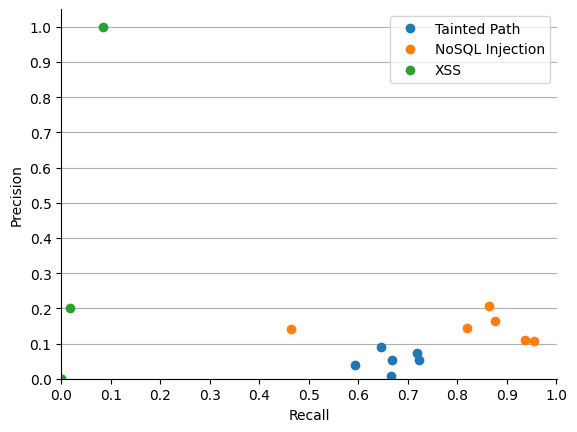

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

fig, axes = plt.subplots(1,1)

for df, name in results_and_name:
    precision =  df.precision.values.tolist()
    recall = df.recall.values.tolist()
    axes.plot(recall, precision, 'o', label=name)
axes.legend()
axes.set_xlim(left=0)
axes.set_ylim(bottom=0)
axes.grid(visible=True, axis='y')
axes.xaxis.set_major_locator(MultipleLocator(.1))
axes.yaxis.set_major_locator(MultipleLocator(.1))
axes.set_xlabel("Recall")
axes.set_ylabel("Precision")
fig.savefig("precision-recall.pdf", format="pdf", bbox_inches="tight")

In [5]:
import numpy as np
for df, name in results_and_name:
    precision =  df.precision.values.tolist()
    recall = df.recall.values.tolist()
    precision_std = np.std(precision)
    recall_std = np.std(recall)
    print(f"{name} - precision std = {precision_std} - recall std = {recall_std}")
    

Tainted Path - precision std = 0.02547756261050893 - recall std = 0.04388069063817512
NoSQL Injection - precision std = 0.03361307531993176 - recall std = 0.16506260135872286
XSS - precision std = 0.36514837167011077 - recall std = 0.03042903097250923


In [6]:
with open("resultados_prec_recall_others.csv", "w") as f:
    results.to_csv(f,float_format='%.4f')

## Revisando XSS

In [7]:
calculate_many_scores(["/home/pablo/dev-results/xss-30-3fold-%d"%i for i in range(3)])

,precision,recall,accuracy,atr,recovered,spurious,progwithatr,avgatr,predsinks,name
0,0.0,0.0,0.0,5,0,0,2,2.500000,100,fold 0
0,0.0,0.0,0.0,5,0,0,2,2.500000,68,fold 1
0,0.0,0.0,0.0,2,0,0,1,2.000000,75,fold 2
mean,0.0,0.0,0.0,4,0,0,1,2.333333,81,mean


In [8]:
import re
from datetime import datetime

time_regex = re.compile(r"\[[A-Z]+\t(.+)\]\sroot")
format_string = "%Y-%m-%d %H:%M:%S,%f"

def get_logline_ts(logline):
    try:
        ts = time_regex.match(logline).group(1)
        parsed_timestamp = datetime.strptime(ts, format_string)
        return parsed_timestamp
    except:
        print(f"error parsing {logline}")
        raise

start 2023-07-30 01:01:53.453000 - end 2023-07-30 03:12:52.343000 - took 2:10:58.890000
start 2023-07-30 03:54:40.122000 - end 2023-07-30 06:42:10.201000 - took 2:47:30.079000
start 2023-07-30 06:46:26.270000 - end 2023-07-30 09:27:41.755000 - took 2:41:15.485000
start 2023-07-30 09:32:17.280000 - end 2023-07-30 11:48:37.753000 - took 2:16:20.473000
start 2023-07-30 11:57:25.918000 - end 2023-07-30 14:40:52.742000 - took 2:43:26.824000
start 2023-07-29 17:59:27.992000 - end 2023-07-29 19:29:17.467000 - took 1:29:49.475000
start 2023-07-29 19:32:22.065000 - end 2023-07-29 20:53:38.865000 - took 1:21:16.800000
start 2023-07-29 20:56:30.364000 - end 2023-07-29 22:15:39.912000 - took 1:19:09.548000
start 2023-07-29 22:18:48.852000 - end 2023-07-29 23:34:03.192000 - took 1:15:14.340000
start 2023-07-29 23:38:28.136000 - end 2023-07-30 00:40:59.903000 - took 1:02:31.767000
start 2023-07-13 00:02:35.778000 - end 2023-07-13 01:19:33.585000 - took 1:16:57.807000
start 2023-07-13 01:20:57.100000

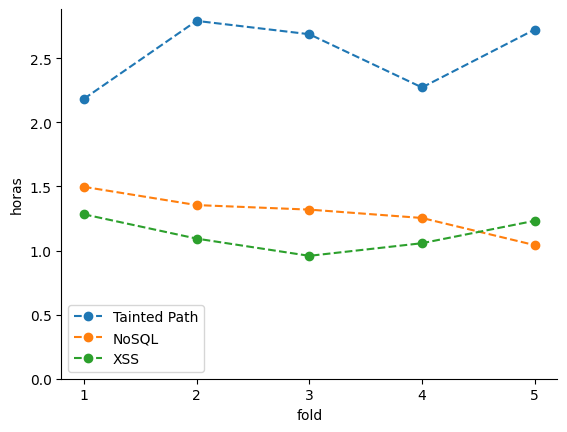

In [29]:
import os
import re
import numpy as np


fig, ax = plt.subplots()

path_time_datas = []
for dir in path_result_dirs:
    with open(os.path.join(dir, "training_log.txt")) as tr:
        lines = tr.readlines()
        start = get_logline_ts(lines[0])
        end = get_logline_ts(lines[-1])
        took = end-start
        path_time_datas.append(took)
        print(f"start {start} - end {end} - took {took}")

nosql_time_datas = []
for dir in nosql_result_dirs:
    with open(os.path.join(dir, "training_log.txt")) as tr:
        lines = tr.readlines()
        start = get_logline_ts(lines[0])
        end = get_logline_ts(lines[-1])
        took = end-start
        nosql_time_datas.append(took)
        print(f"start {start} - end {end} - took {took}")

xss_time_datas = []
for dir in xss_result_dirs:
    with open(os.path.join(dir, "training_log.txt")) as tr:
        lines = tr.readlines()
        start = get_logline_ts(lines[0])
        end = get_logline_ts(lines[-1])
        took = end-start
        xss_time_datas.append(took)
        print(f"start {start} - end {end} - took {took}")

datas = [
    ["Tainted Path", [diff.total_seconds()/3600 for diff in path_time_datas]],
    ["NoSQL", [diff.total_seconds()/3600 for diff in nosql_time_datas]],
    ["XSS", [diff.total_seconds()/3600 for diff in xss_time_datas]],
]

# xs = ['Tainted Path', 'NoSQL Injection', 'XSS']
# means = [np.mean(d) for d in datas]
# errors = [np.std(d) for d in datas]
# print(means)
# print(errors)

xticks=range(1,6)
for [label, data] in datas:
    ax.plot(xticks, data, label=label,marker='o', linestyle='dashed')
ax.set_ylim(bottom=0)
ax.set_xticks(xticks)
ax.set_xlabel('fold')
ax.set_ylabel('horas')
ax.legend()

fig.savefig("runtime_experimentos.pdf", format="pdf", bbox_inches="tight")

# ax.boxplot([
#     [diff.total_seconds()/3600 for diff in path_time_datas],
#     [diff.total_seconds()/3600 for diff in nosql_time_datas],
#     [diff.total_seconds()/3600 for diff in xss_time_datas]
# ], labels=['Tainted Path', 'NoSQL Injection', 'XSS'])
# ax.set_ylim(bottom=0)